## Exercise 1 Hello World

1. Write an MPI program displaying the number of processes used for the execution and the rank of each process.
2. Test the programs obtained with different numbers of threads for the parallel program.

**Output Example**
```shell
Hello from the rank 2 process
Hello from the rank 0 process
Hello from the rank 3 process
Hello from the rank 1 process
Parallel execution of hello_world with 4 process
```
*Note that the output order maybe different*

In [1]:
 %%file hello.py
from mpi4py import MPI
COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

print("Hello from the rank {} process".format(RANK))
if RANK==nbOfproc-1:
    print("Parallel execution of hello_world with {} process".format(nbOfproc))

Overwriting hello.py


In [2]:
# enter command for compile and run the program
! mpirun -n 4 python hello.py

Hello from the rank 0 process
Hello from the rank 2 process
Hello from the rank 1 process
Hello from the rank 3 process
Parallel execution of hello_world with 4 process


## Exercise 2 Sharing Data 

A common need is for one process to get data from the user, either by reading from the terminal or command line arguments, and then to distribute this information to all other processors.

Write a program that reads an integer value from the terminal and distributes the value to all of the MPI processes. Each process should print out its rank and the value it received. Values should be read until a negative integer is given as input.

You may want to use these MPI routines in your solution:
`Get_rank` `Bcast` 

**Output Example**
```shell
10
Process 0 got 10
Process 1 got 10
```

In [4]:
%%file sharing.py
from mpi4py import MPI
COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()
sendb=1
recvb = 1
while recvb > 0:
    if RANK==0:
        sendb=int(input())
    recvb= COMM.bcast(sendb , root=0)
    print("Process {RANK} got {data}".format(RANK=RANK, data=recvb))
    

Overwriting sharing.py


In [5]:
! mpirun -n 2 python sharing.py

^C


## Exercise 3 Sending in a ring (broadcast by ring)

Write a program that takes data from process zero and sends it to all of the other processes by sending it in a ring. That is, process i should receive the data and send it to process i+1, until the last process is reached.
Assume that the data consists of a single integer. Process zero reads the data from the user.
![](../data/ring.gif)

You may want to use these MPI routines in your solution:
`Send` `Recv` 

In [6]:
 %%file sending.py
from mpi4py import MPI
COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()
tag=99
i=0
while i < nbOfproc-1:
    if RANK==i:
        sendb = 1000
        COMM.send ( sendb , dest=i+1, tag=tag )
    if RANK ==i+1:
        recvb = COMM.recv ( source=i , tag=tag )
        print ("Process {RANK} receive {recvb} from {RANKO}".format(RANK=RANK, recvb=recvb, RANKO=RANK-1))
    i=i+1 

Overwriting sending.py


In [7]:
! mpirun -n 4 python sending.py

Process 1 receive 1000 from 0
Process 2 receive 1000 from 1
Process 3 receive 1000 from 2


## Exercise 4 Matrix vector product

1. Use the `MatrixVectorMult.py` file to implement the MPI version of matrix vector multiplication.
2. Process 0 compares the result with the `dot` product.
3. Plot the scalability of your implementation. 

**Output Example**
```shell
CPU time of parallel multiplication using 2 processes is  174.923446
The error comparing to the dot product is : 1.4210854715202004e-14
```

In [8]:
 %%file MatrixVectorMult_V0.py

import numpy as np
from scipy.sparse import lil_matrix
from numpy.random import rand, seed
from numba import njit
from mpi4py import MPI


''' This program compute parallel csc matrix vector multiplication using mpi '''

COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()

seed(42)

def matrixVectorMult(A, b, x):
    
    row, col = A.shape
    for i in range(row):
        a = A[i]
        for j in range(col):
            x[i] += a[j] * b[j]

    return 0

########################initialize matrix A and vector b ######################
#matrix sizes
SIZE = 1000
Local_size = SIZE//nbOfproc

# counts = block of each proc
#counts = 

if RANK == 0:
    A = lil_matrix((SIZE, SIZE))
    A[0, :100] = rand(100)
    A[1, 100:200] = A[0, :100]
    A.setdiag(rand(SIZE))
    A = A.toarray()
    b = rand(SIZE)
else :
    A = None
    b = None



#########Send b to all procs and scatter A (each proc has its own local matrix#####

LocalMatrix = np.zeros((Local_size, SIZE))
COMM.Scatter(A, LocalMatrix, root=0)

# Scatter the matrix A
b=COMM.bcast(b,root=0)



#####################Compute A*b locally#######################################
LocalX = np.zeros(Local_size)


start = MPI.Wtime()
matrixVectorMult(LocalMatrix, b, LocalX)
stop = MPI.Wtime()
if RANK == 0:
    print("CPU time of parallel multiplication is ", (stop - start)*1000)

##################Gather te results ###########################################
#sendcouns = 
sendcounts = np.array(COMM.gather(len(LocalX),root=0))
if RANK == 0: 
    X = np.zeros(sum(sendcounts),dtype=np.double)

else :
    X = None

if RANK == 0:
    print(len(X))
#print(RANK, sendcounts, len(LocalX))
# Gather the result into X
COMM.Gatherv(LocalX, recvbuf=(X, sendcounts, MPI.DOUBLE), root=0)


##################Print the results ###########################################

if RANK == 0 :
    X_ = A.dot(b)
    print("The result of A*b using dot is :", np.max(X_ - X))
    # print("The result of A*b using parallel version is :", X)
    


Overwriting MatrixVectorMult_V0.py


In [5]:
! mpirun -n 4 python MatrixVectorMult_V0.py

CPU time of parallel multiplication is  174.734379
3 None 250
1 None 250
2 None 250
1000
0 [250 250 250 250] 250
The result of A*b using dot is : 1.4210854715202004e-14


Text(0.5, 1.0, 'CPU time per number of processes use to the product Matrix vect')

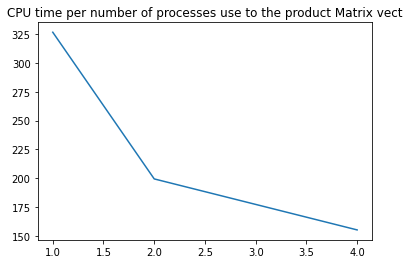

In [8]:
import matplotlib.pyplot as plt
CPU_time=[326.5986, 199.3336, 155.07819]
plt.plot([1,2,4],CPU_time)
plt.title("CPU time per number of processes use to the product Matrix vect")

On remarque que le temps d'exécution diminue avec l'augmentation du nombre de processeur utilisé

## Exercise 5 Calculation of π (Monte Carlo)

1. Use the `PiMonteCarlo.py` file to implement the calculation of PI using Monte Carlo.
2. Process 0 prints the result.
3. Plot the scalability of your implementation. 

In [25]:
 %%file PiMonteCarlo_V0.py

import random 
import timeit
from mpi4py import MPI

COMM = MPI.COMM_WORLD
nbOfproc = COMM.Get_size()
RANK = COMM.Get_rank()



random.seed(42)  

def compute_points(n):
    
    random.seed(42)  
    
    circle_points= 0

    # Total Random numbers generated= possible x 
    # values* possible y values 
    for i in range(n): 
      
        # Randomly generated x and y values from a 
        # uniform distribution 
        # Rannge of x and y values is -1 to 1 
                
        rand_x= random.uniform(-1, 1) 
        rand_y= random.uniform(-1, 1) 
      
        # Distance between (x, y) from the origin 
        origin_dist= rand_x**2 + rand_y**2
      
        # Checking if (x, y) lies inside the circle 
        if origin_dist<= 1: 
            circle_points+= 1
      
        # Estimating value of pi, 
        # pi= 4*(no. of points generated inside the  
        # circle)/ (no. of points generated inside the square) 
    
     
    
    return circle_points

INTERVAL= 1000
a= int((INTERVAL**2)/4)
start = timeit.default_timer()
circle_points = compute_points(a)
end = timeit.default_timer()
pi = 4* circle_points/ INTERVAL**2 
circle_point_reduced = COMM.reduce(circle_points, op=MPI.SUM, root=0)
pi_reduced = COMM.reduce(pi, op=MPI.SUM, root=0)
if RANK==0:
    print("Circle points number :",circle_point_reduced )
    print("Final Estimation of Pi=", pi_reduced, "cpu time :",end-start) 

Overwriting PiMonteCarlo_V0.py


In [26]:
! mpirun -n 4 python PiMonteCarlo_V0.py

Circle points number : 785032
Final Estimation of Pi= 3.140128 cpu time : 0.28276772199933475


Text(0.5, 1.0, 'CPU time per number of processes use to the Pi MonteCarlo ')

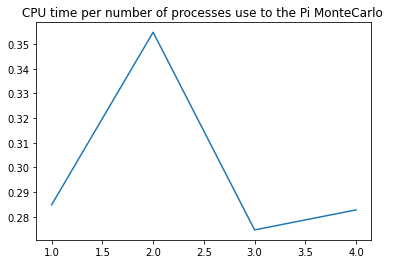

In [27]:
CPU_time=[0.28484, 0.35480, 0.27464, 0.28276]
plt.plot([1, 2, 3, 4],CPU_time)
plt.title("CPU time per number of processes use to the Pi MonteCarlo ")